=== Berlin Dataset ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1100 entries, 2024-04-01 00:00:00 to 2024-12-31 18:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   u10m    1100 non-null   float64
 1   v10m    1100 non-null   float64
 2   lat     1100 non-null   float64
 3   lon     1100 non-null   float64
dtypes: float64(4)
memory usage: 43.0 KB
None
                         u10m      v10m   lat   lon
timestamp                                          
2024-04-01 00:00:00 -1.383750 -1.423712  52.5  13.5
2024-04-01 06:00:00 -4.101521 -0.402939  52.5  13.5
2024-04-01 12:00:00 -3.073844  2.280007  52.5  13.5
2024-04-01 18:00:00  5.741886  2.899093  52.5  13.5
2024-04-02 00:00:00  5.217903  1.938265  52.5  13.5

=== Munich Dataset ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1100 entries, 2024-04-01 00:00:00 to 2024-12-31 18:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  


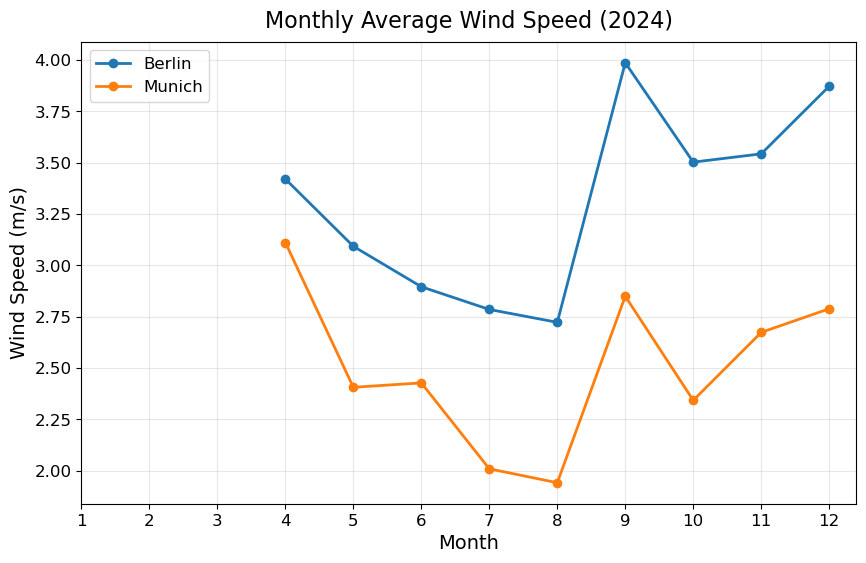

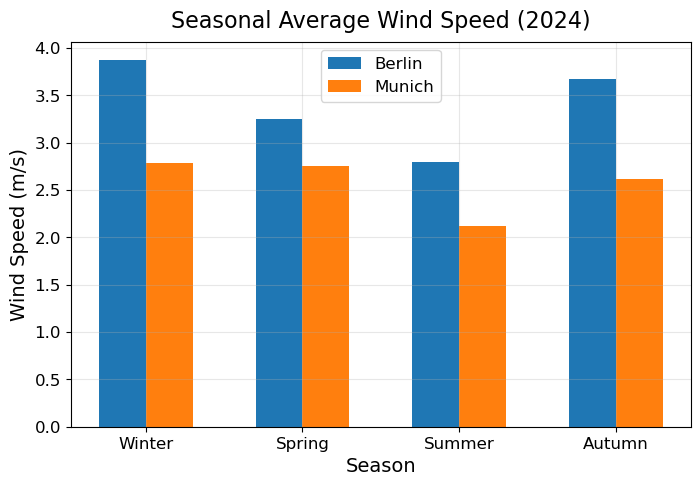

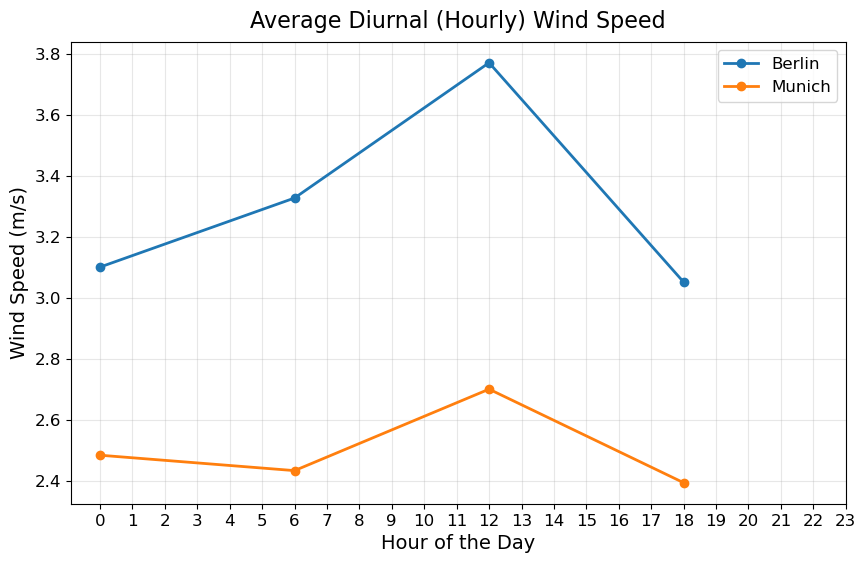


Done! All calculations and plots use the 'timestamp' column as DatetimeIndex.


In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Lab 3: ERA5 Weather Data Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display plots inline (for Jupyter Notebook).
get_ipython().run_line_magic('matplotlib', 'inline')

# -------------------------------------------------------------------------
# 1. LOAD ERA5 DATA WITH "timestamp" COLUMN
# -------------------------------------------------------------------------
def load_era5_data(file_path: str) -> pd.DataFrame:
    """
    Loads ERA5 data from the specified CSV file.
    Assumes the file has a 'timestamp' column in "YYYY-MM-DD HH:MM:SS" format.
    Sets 'timestamp' as DatetimeIndex.
    """
    df = pd.read_csv(file_path)
    
    # Convert 'timestamp' to datetime and set as index
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df.set_index('timestamp', inplace=True)
    df.sort_index(inplace=True)
    
    return df

# Update these paths to match your environment
berlin_file = "../../datasets/berlin_era5_wind_20241231_20241231.csv"
munich_file = "../../datasets/munich_era5_wind_20241231_20241231.csv"

# Load data
df_berlin = load_era5_data(berlin_file)
df_munich = load_era5_data(munich_file)

print("=== Berlin Dataset ===")
print(df_berlin.info())
print(df_berlin.head())

print("\n=== Munich Dataset ===")
print(df_munich.info())
print(df_munich.head())

# -------------------------------------------------------------------------
# 2. CHECK & CLEAN MISSING DATA
# -------------------------------------------------------------------------
print("\nMissing values (Berlin):")
print(df_berlin.isna().sum())

print("\nMissing values (Munich):")
print(df_munich.isna().sum())

# Drop any rows with NaN
df_berlin.dropna(inplace=True)
df_munich.dropna(inplace=True)

# -------------------------------------------------------------------------
# 3. WIND SPEED CALCULATION
# -------------------------------------------------------------------------
def calculate_wind_speed(u: pd.Series, v: pd.Series) -> pd.Series:
    """
    Compute wind speed from horizontal wind components u and v.
    Formula: speed = sqrt(u^2 + v^2)
    """
    return np.sqrt(u**2 + v**2)

# Ensure your CSV has columns named 'u10m' and 'v10m'.
df_berlin['wind_speed'] = calculate_wind_speed(df_berlin['u10m'], df_berlin['v10m'])
df_munich['wind_speed'] = calculate_wind_speed(df_munich['u10m'], df_munich['v10m'])

# -------------------------------------------------------------------------
# 4. TEMPORAL AGGREGATIONS
# -------------------------------------------------------------------------
def monthly_average(df: pd.DataFrame, var: str) -> pd.Series:
    """Group by month of the DatetimeIndex and return the mean of 'var'."""
    return df.groupby(df.index.month)[var].mean()

berlin_monthly_wind = monthly_average(df_berlin, 'wind_speed')
munich_monthly_wind = monthly_average(df_munich, 'wind_speed')

def get_season(month: int) -> int:
    """
    Return season code for the given month:
      1 = Winter, 2 = Spring, 3 = Summer, 4 = Autumn
    """
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    else:
        return 4

# Assign seasons
df_berlin['season'] = df_berlin.index.month.map(get_season)
df_munich['season'] = df_munich.index.month.map(get_season)

berlin_seasonal_wind = df_berlin.groupby('season')['wind_speed'].mean()
munich_seasonal_wind = df_munich.groupby('season')['wind_speed'].mean()

# -------------------------------------------------------------------------
# 5. STATISTICAL ANALYSIS
# -------------------------------------------------------------------------
# 5.1 Extreme Days
df_berlin_daily = df_berlin.resample('D').mean(numeric_only=True)
df_munich_daily = df_munich.resample('D').mean(numeric_only=True)

print("\n=== Top 5 Extreme Wind Speed Days (Berlin) ===")
print(df_berlin_daily['wind_speed'].nlargest(5))

print("\n=== Top 5 Extreme Wind Speed Days (Munich) ===")
print(df_munich_daily['wind_speed'].nlargest(5))

# 5.2 Diurnal Pattern
df_berlin['hour'] = df_berlin.index.hour
df_munich['hour'] = df_munich.index.hour

berlin_hourly_pattern = df_berlin.groupby('hour')['wind_speed'].mean()
munich_hourly_pattern = df_munich.groupby('hour')['wind_speed'].mean()

# -------------------------------------------------------------------------
# 6. VISUALIZATIONS
# -------------------------------------------------------------------------
# Optional improvements to default Matplotlib appearance:
plt.rcParams['figure.facecolor'] = 'white'  # White background for figures
plt.rcParams['axes.facecolor']   = 'white'  # White background for axes
plt.rcParams.update({
    'axes.grid'        : True,    # Show grid lines
    'grid.alpha'       : 0.3,     # Light grid lines
    'lines.linewidth'  : 2.0,     # Thicker lines
    'lines.markersize' : 6,       # Larger markers
    'font.size'        : 12,      # Increase default font size
})

# 6.1 Monthly Average Wind Speed
plt.figure(figsize=(10, 6))
plt.plot(berlin_monthly_wind.index, berlin_monthly_wind.values, marker='o', label='Berlin')
plt.plot(munich_monthly_wind.index, munich_monthly_wind.values, marker='o', label='Munich')
plt.title("Monthly Average Wind Speed (2024)", fontsize=16, pad=10)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.xticks(range(1, 13))
plt.legend(fontsize=12)
plt.show()

# 6.2 Seasonal Comparison
season_labels = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}

plt.figure(figsize=(8, 5))
plt.bar(berlin_seasonal_wind.index - 0.15, berlin_seasonal_wind.values, width=0.3, label='Berlin')
plt.bar(munich_seasonal_wind.index + 0.15, munich_seasonal_wind.values, width=0.3, label='Munich')
plt.title("Seasonal Average Wind Speed (2024)", fontsize=16, pad=10)
plt.xlabel("Season", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.xticks([1, 2, 3, 4], [season_labels[s] for s in [1, 2, 3, 4]], fontsize=12)
plt.legend(fontsize=12)
plt.show()

# 6.3 Diurnal (Hourly) Pattern
plt.figure(figsize=(10, 6))
plt.plot(berlin_hourly_pattern.index, berlin_hourly_pattern.values, marker='o', label='Berlin')
plt.plot(munich_hourly_pattern.index, munich_hourly_pattern.values, marker='o', label='Munich')
plt.title("Average Diurnal (Hourly) Wind Speed", fontsize=16, pad=10)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.xticks(range(0, 24))
plt.legend(fontsize=12)
plt.show()

# -------------------------------------------------------------------------
# 7. SKYRIM & GIT NOTES
# -------------------------------------------------------------------------
print("\nDone! All calculations and plots use the 'timestamp' column as DatetimeIndex.")
